In [ ]:
# Cell 1 – imports & load data
import gc, json
import numpy as np
import pandas as pd
import lightgbm as lgb
import pyarrow.parquet as pq

META_PATH = '../data/outputs/dataset_meta.json'
TRAIN_RANK_PATH = '../data/outputs/train_rank.parquet'
VALID_RANK_PATH = '../data/outputs/valid_rank.parquet'
GROUP_TRAIN_PATH = '../data/outputs/groups_train.npy'
GROUP_VALID_PATH = '../data/outputs/groups_valid.npy'
MODEL_PATH = "../data/outputs/lgbm_ranker.model"
FEATURES_PATH = "../data/outputs/features_week=20200922.parquet"
SAMPLE_PATH = "../data/input_data/sample_submission.csv"
GENERAL_PATH = "../data/outputs/general_pred_str.json"

# Load metadata
with open(META_PATH) as f:
    meta = json.load(f)

feature_cols = meta['model_features']

# ---------------------------------------------------------
# REMOVE FEATURES HERE
# ---------------------------------------------------------
remove_features = [
    # 'value',
    # 'age_bucket',
    # 'customer_total_purchases',
    # 'customer_unique_articles',
    # 'cust_purchases_1w',
    # 'cust_purchases_4w',
    # 'article_total_purchases',
    # 'article_unique_customers',
    #'club_member_status',
    #'fashion_news_frequency',
    #'age',
    #'postal_code',
    #'product_code',
    #'product_type_no',
    #'product_group_name',
    #'graphical_appearance_no',
    #'colour_group_code',
    #'perceived_colour_value_id',
    #'perceived_colour_master_id',
    #'department_no',
    #'index_code',
    #'index_group_no',
    #'section_no',
    #'garment_group_no',
    # 'article_mean_price',
    # 'customer_mean_price',
    # 'article_mean_age',
    # 'index_group_match',
    # 'product_code_match',
    # 'days_since_last_purchase',
    # 'customer_days_since_last_purchase',
    # 'price_sensitivity',
    # 'age_sensitivity',
    # 'window_type_code',
]

feature_cols = [f for f in feature_cols if f not in remove_features]

print("Available model features:")
for f in feature_cols:
    print(f)


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/distributed/diagnostics/rmm.py:8: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
  import rmm
/home/coder/ICTProject/.venv/lib/python3.11/site-packages/rmm/__init__.py:15: FutureWarning: The cuda.cuda module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.driver module instead.
  from rmm import mr


Available model features:
value
age_bucket
customer_total_purchases
customer_unique_articles
cust_purchases_1w
cust_purchases_4w
article_total_purchases
article_unique_customers
club_member_status
fashion_news_frequency
age
postal_code
product_code
product_type_no
product_group_name
graphical_appearance_no
colour_group_code
perceived_colour_value_id
perceived_colour_master_id
department_no
index_code
index_group_no
section_no
garment_group_no
article_mean_price
customer_mean_price
article_mean_age
index_group_match
product_code_match
days_since_last_purchase
customer_days_since_last_purchase
price_sensitivity
age_sensitivity
window_type_code


In [ ]:
# ---------------------------------------------------------
# LOAD TRAIN
# ---------------------------------------------------------
train_df = pd.read_parquet(TRAIN_RANK_PATH)

# DROP REMOVED FEATURES FROM TRAIN
cols_to_drop = [c for c in remove_features if c in train_df.columns]
if cols_to_drop:
    print("Dropping from TRAIN:", cols_to_drop)
    train_df = train_df.drop(columns=cols_to_drop)

train_group = np.load(GROUP_TRAIN_PATH)
print("Train rows:", len(train_df))

# ---------------------------------------------------------
# LOAD VALID IN STREAMING MODE
# ---------------------------------------------------------
VALID_FRACTION = 1.0

print("\nLoading VALID dataset streaming...")
valid_reader = pq.ParquetFile(VALID_RANK_PATH)

valid_batches = []
BATCH_SIZE = 5_000_000

for batch_idx, batch in enumerate(valid_reader.iter_batches(batch_size=BATCH_SIZE)):
    df_chunk = batch.to_pandas()

    # Drop removed features here too
    for c in cols_to_drop:
        if c in df_chunk.columns:
            df_chunk = df_chunk.drop(columns=c)

    if VALID_FRACTION < 1.0:
        df_chunk = df_chunk.sample(frac=VALID_FRACTION, random_state=42 + batch_idx)

    valid_batches.append(df_chunk)
    del df_chunk
    gc.collect()

valid_df = pd.concat(valid_batches, ignore_index=True)
del valid_batches
gc.collect()

print("Valid rows:", len(valid_df))

# Use precomputed groups aligned to on-disk row order
valid_group = np.load(GROUP_VALID_PATH)
assert valid_group.sum() == len(valid_df), "Valid group mismatch with loaded dataframe!"

print("\nFinal Stats:")
print("Features:", len(feature_cols))
print("Train groups:", len(train_group))
print("Valid groups:", len(valid_group))

#45s


Train rows: 8180082

Loading VALID dataset streaming...
Valid rows: 253714158

Final Stats:
Features: 34
Train groups: 294983
Valid groups: 1371980


In [3]:
# cell 3
# ---------------------------------------------------------
# FILTER VALIDATION: Only evaluate on groups with at least 1 positive
# This removes the "fake 1.0" scores from groups where we missed the item entirely.
# ---------------------------------------------------------
print("\nFiltering validation set to groups with at least 1 positive...")

# 1. Identify which groups have a positive label
# We use numpy for speed (pandas groupby is slow on 30M rows)
# valid_group contains the size of each group
group_boundaries = np.insert(np.cumsum(valid_group), 0, 0)[:-1]
group_has_positive = np.add.reduceat(valid_df['label'].values, group_boundaries) > 0

# 2. Filter groups array
valid_group_filtered = valid_group[group_has_positive]

# 3. Filter dataframe
# Expand the group mask back to row mask to filter the dataframe
row_mask = np.repeat(group_has_positive, valid_group)
valid_df = valid_df[row_mask].reset_index(drop=True)
valid_group = valid_group_filtered

print(f"Filtered Valid Groups: {len(group_has_positive)} -> {len(valid_group)}")
print(f"Filtered Valid Rows: {len(row_mask)} -> {len(valid_df)}")


Filtering validation set to groups with at least 1 positive...
Filtered Valid Groups: 1371980 -> 27802
Filtered Valid Rows: 253714158 -> 8372080


In [ ]:
## cell 4

ranker_params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'eval_at': [12],
    'learning_rate': 0.15,
    'max_depth': 6,
    'num_leaves': 63,
    'min_data_in_leaf': 120,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l2': 5,
    'verbosity': -1,
    'n_estimators': 2000,
}

ranker = lgb.LGBMRanker(**ranker_params)

evals_result = {}

ranker.fit(
    train_df[feature_cols],
    train_df['label'],
    group=train_group,
    eval_set=[
        (train_df[feature_cols], train_df['label']),
        (valid_df[feature_cols], valid_df['label'])
    ],
    eval_group=[train_group, valid_group],
    eval_names=['train', 'valid'],
    eval_at=[12],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=1),
        lgb.record_evaluation(evals_result),
    ],
)

# ==========================================================
# Retrieve best validation metric safely
# ==========================================================
print("Best iteration:", ranker.best_iteration_)

best_scores = ranker.best_score_

if "valid" in best_scores:
    best_ndcg = best_scores["valid"]["ndcg@12"]
elif "valid_0" in best_scores and "ndcg@12" in best_scores["valid_0"]:
    best_ndcg = best_scores["valid_0"]["ndcg@12"]
else:
    raise KeyError("Could not find validation ndcg@12 in best_score_")

print("Best valid NDCG@12:", best_ndcg)

# Save model
ranker.booster_.save_model("../data/outputs/lgbm_ranker.model")
print("Model saved.")

# ==========================================================
# Save training log to TXT
# ==========================================================
log_path = "../data/outputs/lgbm_training_log.txt"

train_log = evals_result.get("train", {}).get("ndcg@12", [])
valid_log = evals_result.get("valid", {}).get("ndcg@12", [])

max_len = min(len(train_log), len(valid_log))

with open(log_path, "w") as f:
    f.write("iter,train_ndcg12,valid_ndcg12\n")
    for i in range(max_len):
        f.write(f"{i},{train_log[i]},{valid_log[i]}\n")

print("Saved training log to:", log_path)

gc.collect()



/home/coder/ICTProject/.venv/lib/python3.11/site-packages/lightgbm/sklearn.py:861: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[1]	train's ndcg@12: 0.775333	valid's ndcg@12: 0.134142
Training until validation scores don't improve for 200 rounds
[2]	train's ndcg@12: 0.782695	valid's ndcg@12: 0.142129
[3]	train's ndcg@12: 0.7842	valid's ndcg@12: 0.144431
[4]	train's ndcg@12: 0.784941	valid's ndcg@12: 0.146302
[5]	train's ndcg@12: 0.785912	valid's ndcg@12: 0.147424
[6]	train's ndcg@12: 0.786046	valid's ndcg@12: 0.148095
[7]	train's ndcg@12: 0.786417	valid's ndcg@12: 0.148243
[8]	train's ndcg@12: 0.788197	valid's ndcg@12: 0.150718
[9]	train's ndcg@12: 0.789204	valid's ndcg@12: 0.151333
[10]	train's ndcg@12: 0.789808	valid's ndcg@12: 0.15163
[11]	train's ndcg@12: 0.790477	valid's ndcg@12: 0.154178
[12]	train's ndcg@12: 0.791036	valid's ndcg@12: 0.154352
[13]	train's ndcg@12: 0.791817	valid's ndcg@12: 0.15545
[14]	train's ndcg@12: 0.792141	valid's ndcg@12: 0.155859
[15]	train's ndcg@12: 0.7925	valid's ndcg@12: 0.155564
[16]	train's ndcg@12: 0.792897	valid's ndcg@12: 0.155785
[17]	train's ndcg@12: 0.793203	valid's nd

211

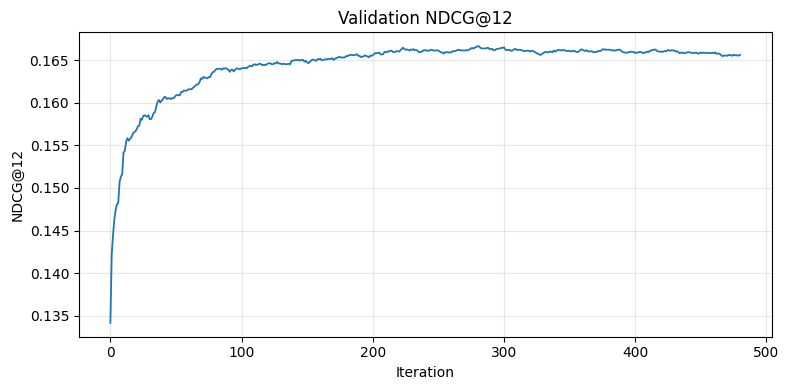

In [5]:
# %% 
# Cell A — Plot validation NDCG@12 over iterations

import pandas as pd
import matplotlib.pyplot as plt

log_path = "../data/outputs/lgbm_training_log.txt"

df_log = pd.read_csv(log_path)

plt.figure(figsize=(8,4))
plt.plot(df_log["iter"], df_log["valid_ndcg12"], linewidth=1.3)
plt.title("Validation NDCG@12")
plt.xlabel("Iteration")
plt.ylabel("NDCG@12")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



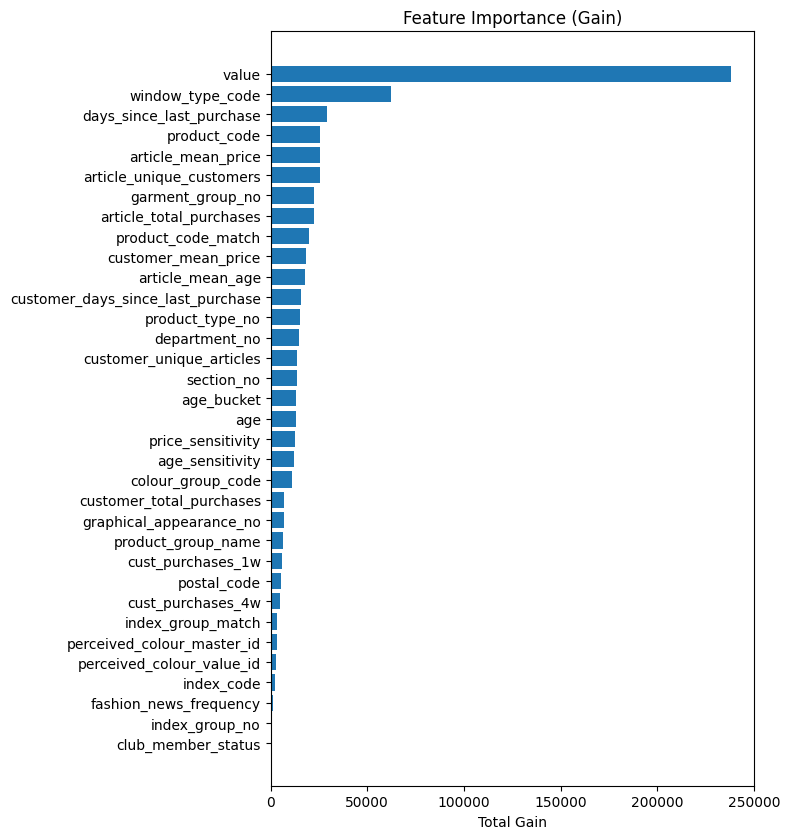

In [6]:
# %%
# Cell B — Feature importance bar plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Collect importance values
importances = ranker.booster_.feature_importance(importance_type="gain")
feature_names = ranker.booster_.feature_name()

# Build a dataframe
fi = pd.DataFrame({
    "feature": feature_names,
    "gain": importances
})

# Sort descending
fi = fi.sort_values("gain", ascending=True)

plt.figure(figsize=(8, max(4, len(fi) * 0.25)))
plt.barh(fi["feature"], fi["gain"])
plt.title("Feature Importance (Gain)")
plt.xlabel("Total Gain")
plt.tight_layout()
plt.show()


In [8]:
# Cell 5 – INFERENCE: Load model and features
print("\nLoading model for inference...")
model = lgb.Booster(model_file=MODEL_PATH)

print("Loading submission week features...")
data = pd.read_parquet(
    FEATURES_PATH,
    columns=["customer_id", "article_id"] + feature_cols
)

print("Rows:", len(data))
print("Customers:", data["customer_id"].nunique())


Loading model for inference...
Loading submission week features...
Rows: 250982495
Customers: 1371980


In [ ]:
# Cell 6 – INFERENCE: Predict scores in batches
BATCH_SIZE = 2_000_000
n_rows = len(data)
scores = np.empty(n_rows, dtype=np.float32)

print("Running inference...")

for start in range(0, n_rows, BATCH_SIZE):
    end = min(start + BATCH_SIZE, n_rows)
    X_batch = data.iloc[start:end][feature_cols]
    scores[start:end] = model.predict(X_batch, num_iteration=model.best_iteration)
    del X_batch
    gc.collect()
    print(f"Predicted rows {start:,} to {end:,}")

data["score"] = scores
del scores
gc.collect()
print("Scored data rows:", len(data))

# 15 min

Running inference...
Predicted rows 0 to 2,000,000
Predicted rows 2,000,000 to 4,000,000
Predicted rows 4,000,000 to 6,000,000
Predicted rows 6,000,000 to 8,000,000
Predicted rows 8,000,000 to 10,000,000
Predicted rows 10,000,000 to 12,000,000
Predicted rows 12,000,000 to 14,000,000
Predicted rows 14,000,000 to 16,000,000
Predicted rows 16,000,000 to 18,000,000
Predicted rows 18,000,000 to 20,000,000
Predicted rows 20,000,000 to 22,000,000
Predicted rows 22,000,000 to 24,000,000
Predicted rows 24,000,000 to 26,000,000
Predicted rows 26,000,000 to 28,000,000
Predicted rows 28,000,000 to 30,000,000
Predicted rows 30,000,000 to 32,000,000
Predicted rows 32,000,000 to 34,000,000
Predicted rows 34,000,000 to 36,000,000
Predicted rows 36,000,000 to 38,000,000
Predicted rows 38,000,000 to 40,000,000
Predicted rows 40,000,000 to 42,000,000
Predicted rows 42,000,000 to 44,000,000
Predicted rows 44,000,000 to 46,000,000
Predicted rows 46,000,000 to 48,000,000
Predicted rows 48,000,000 to 50,000,

In [ ]:
# Cell 7 – INFERENCE: Top 12 per customer
data = data.sort_values(["customer_id", "score"], ascending=[True, False])
top12 = data.groupby("customer_id", group_keys=False).head(12)

top12["article_id_str"] = top12["article_id"].astype(str).str.zfill(10)

pred_df = (
    top12.groupby("customer_id")["article_id_str"]
         .apply(lambda x: " ".join(x))
         .reset_index()
         .rename(columns={"customer_id": "customer_id_int",
                          "article_id_str": "prediction"})
)

print("Predictions built:", len(pred_df))
del top12
gc.collect()

# 8 min, 5 sec

/tmp/ipykernel_29232/4223324788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top12["article_id_str"] = top12["article_id"].astype(str).str.zfill(10)


Predictions built: 1371980


0

In [11]:
# Cell 8 – INFERENCE: Merge with sample and apply fallback
sample = pd.read_csv(SAMPLE_PATH)
sample["customer_id_int"] = sample["customer_id"].str[-16:].apply(lambda h: int(h, 16)).astype("int64")
sample = sample.drop(columns=["prediction"], errors="ignore")

pred_df["customer_id_int"] = pred_df["customer_id_int"].astype("int64")

print("Sample customers:", sample["customer_id_int"].nunique())
print("Predicted customers:", pred_df["customer_id_int"].nunique())

sub = sample.merge(pred_df, how="left", on="customer_id_int")
print("Predictions matched:", sub["prediction"].notna().sum())

del sample, pred_df
gc.collect()

gp = json.load(open(GENERAL_PATH))
fallback_str = gp["general_pred_str"]
fallback_items = fallback_str.split()

sub["prediction"] = sub["prediction"].fillna(fallback_str)

Sample customers: 1371980
Predicted customers: 1371980
Predictions matched: 1371980


In [13]:
# Cell 9 – INFERENCE: Pad to 12 items and save
def pad_to_12(pred):
    items = pred.split()
    if len(items) >= 12:
        return " ".join(items[:12])
    seen = set(items)
    for art in fallback_items:
        if art not in seen:
            items.append(art)
        if len(items) == 12:
            break
    return " ".join(items)

sub["prediction"] = sub["prediction"].apply(pad_to_12)

out_path = "../data/submission/lgbm_ranker_submission.csv"
sub[["customer_id", "prediction"]].to_csv(out_path, index=False)

print("Submission saved to:", out_path)
sub.head()

Submission saved to: ../data/submission/lgbm_ranker_submission.csv


,customer_id,customer_id_int,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,6883939031699146327,0568601043 0568601006 0568601044 0568601007 08...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,-7200416642310594310,0673677002 0918522001 0448509014 0915526001 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-6846340800584936,0794321007 0794321011 0794321008 0918522001 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,-94071612138601410,0794321011 0804992017 0730683050 0805000001 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,-283965518499174310,0896152002 0730683050 0730683062 0896152001 07...
